# Stroke Risk Analysis

## 1. Project Background

Stroke is defined as a medical condition in which there is poor blood flow towards the brain, leading to cell death. The World Health Organization cites stroke as the 2nd leading cause of death globally, accounting for approximately 11% of total deaths. 

This project aims to build a predictive model to assess the likelihood of the onset of stroke of a patient using various potential parameters such as gender, age, medical history and smoking status. Ideally, the model should prioritise identifyingh high-risk patients while maintaining clinical practicality, ensuring that healthcare professionals can rely on the predictions for decision-making support.

The original data was obtained from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset). In order to simulate real-world data issues, the dataset has been purposefully augmented to include formatting inconsistencies, missing values, duplicate entries as well as invalid values. The augmented dataset can be viewed [here](../data/stroke_dataset_messy.csv).

This notebook focuses on the process of data cleaning as well as performing exploratory data analysis to analyse the target variables and its potential features, individually and how they interact with one another in order to shortlist the strongest predictors of stroke.

### Table of Contents

1. [Project Background](#1-project-background)
2. [Importing Packages](#2-importing-packages)
3. [Data Overview](#3-data-overview)
4. [Data Quality Assessment](#4-data-quality-assessment)
5. [Data Cleaning](#5-data-cleaning)
6. [Target Variable Analysis](#6-target-variable-analysis)
7. [Univariate Analysis for Features](#7-univariate-analysis-for-features)
8. [Bivariate Analysis of Features and Targets](#8-bivariate-analysis-of-features-and-target)
9. [Bivariate Analysis amongst Features](#9-bivariate-analysis-amongst-features)
10. [Feature Engineering and Selection](#10-feature-engineering-and-selection)

## 2. Importing Packages

In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from scipy.stats import chi2_contingency
from itertools import combinations

sys.path.append('..')
from src import standardize_capitalisation_and_spacing, impute_by_mode, impute_by_median

## 3. Data Overview

In [327]:
df_raw = pd.read_csv("../data/stroke_dataset_messy.csv")
df_raw.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,7885,Female,23.0,0,0,No,Private,Rural,92.26,17.1,Unknown,0
1,39120,FEMALE,82.0,0,0,No,Self-employed,Urban,82.21,26.0,never smoked,0
2,73740,male,26.0,0,0,No,Private,Urban,103.61,31.4,never smoked,0
3,14404,Female,13.0,0,0,NO,children,Urban,94.12,20.1,never smoked,0
4,73346,Female,25.5,NaN,No,NaN,Student,Urban,9999,0,,99
5,937,Male,7.0,0,0,No,children,Urban,87.94,NaN,Unknown,0
6,39308,Male,62.0,0,0,Yes,Private,City,145.37,33.3,UNKNOWN,0
7,2082,Male,35.0,0,0,Yes,Private,Rural,115.92,NaN,formerly smoked,0
8,46434,Male,52.0,1,0,Yes,Govt_job,Urban,214.43,39.9,smokes,0
9,48851,Female,9.0,0,0,No,children,Rural,77.67,17.6,?,0


In [328]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6029 entries, 0 to 6028
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 6029 non-null   int64 
 1   gender             5958 non-null   object
 2   age                5943 non-null   object
 3   hypertension       5880 non-null   object
 4   heart_disease      5887 non-null   object
 5   ever_married       5919 non-null   object
 6   work_type          5939 non-null   object
 7   Residence_type     5898 non-null   object
 8   avg_glucose_level  5902 non-null   object
 9   bmi                5613 non-null   object
 10  smoking_status     5921 non-null   object
 11  stroke             5901 non-null   object
dtypes: int64(1), object(11)
memory usage: 565.3+ KB


In [329]:
df_raw.describe()

,id
count,6029.000000
mean,42139.775751
std,23565.427945
min,67.000000
25%,21625.000000
50%,43454.000000
75%,64582.000000
max,73859.000000


In [330]:
df_raw.shape

(6029, 12)

### Conceptualising the Dataset

Each row of the dataset represents patient information and each patient is uniquely identified by their id. The most important column is `stroke`, which is the target variable for modelling. The other columns serve as potential features that may influence whether a patient is likely to have stroke or not. Some of these are demographics (age, gender, marital status, work type, residential type), medical history (hypertension, heart disease), lifestyle (smoking status) and clinical measurements (bmi, glucose level).


## 4. Data Quality Assessment

### Duplicate Value Analysis

In [331]:
num_dupes = int(df_raw.duplicated().sum())
print(f"Number of duplicate values: {num_dupes}")

Number of duplicate values: 0


There are no duplicate values in the dataset, which reinforces the uniqueness of the `id` column and that each id corresponds to a unique patient.

### Missing Value Analysis

                   Number of Missing Values  Proportion of Missing Values
bmi                                     416                          6.90
hypertension                            149                          2.47
heart_disease                           142                          2.36
Residence_type                          131                          2.17
stroke                                  128                          2.12
avg_glucose_level                       127                          2.11
ever_married                            110                          1.82
smoking_status                          108                          1.79
work_type                                90                          1.49
age                                      86                          1.43
gender                                   71                          1.18
id                                        0                          0.00


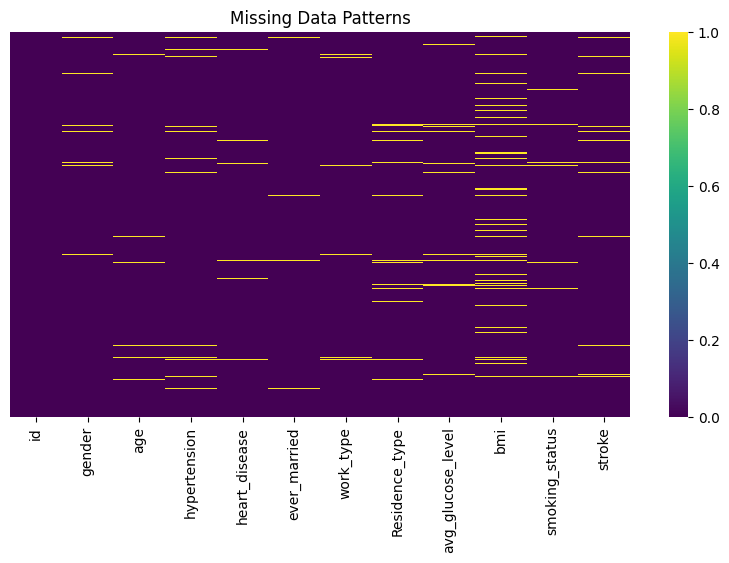

In [332]:
missing_values = pd.DataFrame({
    "Number of Missing Values": df_raw.isna().sum(),
    "Proportion of Missing Values": round(df_raw.isna().sum()/ len(df_raw) * 100, 2)})

print(missing_values.sort_values("Proportion of Missing Values", ascending= False))

plt.figure(figsize= (10,5))
sns.heatmap(df_raw.isnull(), yticklabels= False, cbar = True, cmap = 'viridis')
plt.title("Missing Data Patterns")
plt.show()

All columns except `id` contain missing values. While the proportion of missing values in each column is within reason (< 10%), the pattern of missing values requires careful examination before proceeding with exploratory data analysis.

The heatmap visualisation shows that missing values are missing completely at random, with scattered yellow lines (indicating missing values) and no thick horizontal or vertical bands in the chart. This means that there is no hidden bias in the missing values and the missing values can be addressed either through deletion or imputation.

The following columns: `bmi`, `heart_disease`, `hypertension`, `stroke` are of concern as the proportion of missing values exceed 5% and require more careful handling during the data cleaning stage.

### Formatting Analysis

In [333]:
df_raw["gender"].unique()
df_raw["age"].unique()
df_raw["hypertension"].unique()
df_raw["heart_disease"].unique()
df_raw["ever_married"].unique()
df_raw["work_type"].unique()
df_raw["Residence_type"].unique()
df_raw['avg_glucose_level'].unique()
df_raw["bmi"].unique()
df_raw["smoking_status"].unique()
df_raw["stroke"].unique()

array(['0', '99', '1', nan, 'No', 'Unknown', '2', '-1', 'Yes'],
      dtype=object)

Investigation of the values in each of these fields found multiple errors that need to be addressed during the data cleaning stage.

**Membership Constraints in Categorical Columns**: Categorical columns (`gender`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`, `stroke`) contain invalid values that do not fit into the assigned categories listed in the data card. Additionally, there are many similar entries that are assigned as different categories because of differing capitalisation and spacings.

**Formatting Inconsistencies in Numerical Columns**: Numeric columns contain units of measurements (e.g. 23.1 kg/m2) and irregular decimal formatting ('4.0.0').

**Invalid Values in Numerical Columns**: Some values in the `age` column are deemed invalid as they are below 0 and above 100. There are also float values which need to be rounded down so that the values in the column are discrete numeric values. The same errors can be found in the `bmi` column which contain string values (e.g. "Obese"), negative errors and extreme values (> 50).

**Wrong Column Types**: Columns in the dataset are not properly formatted into the correct data types to be consistent to their values.

## 5. Data Cleaning

### Addressing Formatting Inconsistencies

In [334]:
df_copy = df_raw.copy()

standardize_capitalisation_and_spacing(df_copy)

Trailing spaces were removed from all columns, and all string values have been converted to lower case, with the first letter capitalised. This is to ensure consistent spelling and categorization especially for categorical columns to collapse as many categories together that may have been otherwise separated.

#### Categorical Columns

In [335]:
#df_copy["gender"].unique()

gender_mapping = {
    'F': 'Female',
    'Woman': 'Female',
    
    'M': 'Male',
    'Man': 'Male',

    'Non-binary': 'Other',

    'Prefer not to say': np.nan,
    'Nan': np.nan,
    '': np.nan,
    '?': np.nan,
    'Unknown': np.nan
}

df_copy['gender'] = df_copy['gender'].replace(gender_mapping)
df_copy["gender"] = df_copy["gender"].astype("category")
df_copy["gender"].unique()


['Female', 'Male', NaN, 'Other']
Categories (3, object): ['Female', 'Male', 'Other']

In [336]:
#df_copy["hypertension"].unique()

hypertension_mapping = {
    'Yes': '1',

    'No': '0',

    '2': np.nan,
    'Nan': np.nan,
    '-1': np.nan,
    'Unknown': np.nan,
    '99': np.nan

}

df_copy['hypertension'] = df_copy['hypertension'].replace(hypertension_mapping)
df_copy["hypertension"] = df_copy["hypertension"].astype("category")
df_copy["hypertension"].unique()

['0', NaN, '1']
Categories (2, object): ['0', '1']

In [337]:
#df_copy["heart_disease"].unique()

heart_disease_mapping = {
    'Yes': '1',

    'No': '0',

    '2': np.nan,
    'Nan': np.nan,
    '-1': np.nan,
    'Unknown': np.nan,
    '99': np.nan

}

df_copy['heart_disease'] = df_copy['heart_disease'].replace(heart_disease_mapping)
df_copy["heart_disease"] = df_copy["heart_disease"].astype("category")
df_copy["heart_disease"].unique()

['0', '1', NaN]
Categories (2, object): ['0', '1']

In [338]:
#df_copy["ever_married"].unique()

marital_mapping = {
    'True': 'Yes',
    'Divorced': 'Yes',
    'Married': 'Yes',
    'Y': 'Yes',

    'False': 'No',
    'N': 'No',
    'Single': 'No',

    'Unknown': np.nan,
    '': np.nan,
    'Nan': np.nan
    
}

df_copy["ever_married"] = df_copy['ever_married'].replace(marital_mapping)
df_copy["ever_married"] = df_copy["ever_married"].astype("category")
df_copy["ever_married"].unique()

['No', NaN, 'Yes']
Categories (2, object): ['No', 'Yes']

In [339]:
#df_copy['work_type'].unique()

work_mapping = {
    "Private sector": "Private",

    "Child": 'Children',
    "Student": 'Children',

    "Government": "Govt_job",
    "Public sector": "Govt_job",

    "Retired": "Never_worked",
    "Unemployed": 'Never_worked',
    "Never worked": "Never_worked",

    "Freelance": "Self-employed",
    "Self employed": "Self-employed",

    "Unknown": np.nan,
    "Nan": np.nan
}

df_copy["work_type"] = df_copy["work_type"].replace(work_mapping)
df_copy["work_type"] = df_copy["work_type"].astype("category")
df_copy["work_type"].unique()

['Private', 'Self-employed', 'Children', 'Govt_job', NaN, 'Never_worked']
Categories (5, object): ['Children', 'Govt_job', 'Never_worked', 'Private', 'Self-employed']

In [340]:
#df_copy["Residence_type"].unique()

residence_mapping ={
    
    'Village': 'Rural',

    'City': 'Urban',
    'Suburban': 'Urban',

    'Nan': np.nan,
    'Unknown': np.nan,
    '': np.nan

}

df_copy["Residence_type"] = df_copy["Residence_type"].replace(residence_mapping)
df_copy["Residence_type"] = df_copy["Residence_type"].astype("category")
df_copy["Residence_type"].unique()

['Rural', 'Urban', NaN]
Categories (2, object): ['Rural', 'Urban']

In [341]:
#df_copy['smoking_status'].unique()

smoking_mapping = {

    "Nan": "Unknown",
    "Not known": "Unknown",
    '?': "Unknown",
    '': 'Unknown',

    "Never_smoked": "Never smoked",
    "Non-smoker": "Never smoked",

    "Ex-smoker": "Formerly smoked",
    "Formerly_smoked": "Formerly smoked",

    "Current smoker": "Smokes",
    "Smoker": "Smokes",

}

df_copy["smoking_status"] = df_copy['smoking_status'].replace(smoking_mapping)
df_copy["smoking_status"] = df_copy["smoking_status"].astype("category")
df_copy['smoking_status'].unique()

['Unknown', 'Never smoked', 'Formerly smoked', 'Smokes']
Categories (4, object): ['Formerly smoked', 'Never smoked', 'Smokes', 'Unknown']

In [342]:
#df_copy["stroke"].unique()

stroke_mapping = {

    'Yes': '1',

    'No': '0',

    'Nan': np.nan,
    "2": np.nan,
    '-1': np.nan,
    'Unknown': np.nan,
    '99': np.nan

}

df_copy["stroke"] = df_copy['stroke'].replace(stroke_mapping)
df_copy["stroke"] = df_copy["stroke"].astype("category")
df_copy["stroke"].unique()

['0', NaN, '1']
Categories (2, object): ['0', '1']

To ensure consistency across categorical variables, inconsistent entries were cleaned by mapping similar values to standardized categories in the data card. Entries with spelling inconsistencies and shorthand notations were mapped to their correct forms. Empty or invalid values were replaced with nan values.

`hypertension`, `heart_disease` & `stroke`: These columns only accept binary values ("0" for absence of disease, "1" for presence of disease). Values like "Yes" and "No" were mapped to "1" and "0" respectively. Entries labelled "Unknown" and out-of-range numeric values ("2", "-1" & "99") are ambiguous and not indicative of the presence or absence of disease, and were converted to nan values.

`gender`: Gender values belong to one of three classes: "Male", "Female", and "Other". Shorthand notations and nouns referring to gender identity were mapped to their corresponding classes ("F" and "Woman" to "Female", "M" and "Man" to "Male"). Entries labelled "Non-binary" were mapped to "Other" as they do not fit into the typical "Male" and "Female" category. The remaining entries ("", "?", "Unknown", "Prefer not to say") were ambiguous and converted to nan values as they cannot be reliably classified into any of the three categories.

`ever_married`: This column only accepts 'Yes' or 'No' values. Entries indicating a current or previous marital status ('True', "Divorced", "Married", "Y") were mapped to "Yes" and those indicating that patients were never married ("Single", "False", "N") were mapped to "No". Missing and unknown values were converted to nan.

`work_type`: Work type categories were consolidated into their standardized groups. Employment-related entries were mapped as follows: "Private sector" to "Private", government-related work ("Government", "Public sector") to "Govt_job", and self-employed variants ("Freelance", "Self employed") to "Self-employed". Non-working individuals were grouped by category: dependents ("Child", "Student") were mapped to "Children", while those not in the workforce ("Retired", "Unemployed", "Never worked") were mapped to "Never_worked". Unknown entries were converted to nan.

`Residence_type`: The type of residence can only be classified as either "Rural" or "Urban". Entries indicating more remote living ("Village") were mapped to "Rural", and those indicating a more developed area ("City", "Suburban") were mapped to "Urban". Unknown and missing entries were converted to nan. 

`smoking_status`: Smoking status values were standardized into their consistent categories. Current smoking indicators ("Current smoker", "Smoker") were mapped to "Smokes", past smoking history ("Ex-smoker", "Formerly_smoked") were mapped to "Formerly smoked", and non-smoking indicators ("Never_smoked", "Non-smoker") were mapped to "Never smoked". Ambiguous and missing entries were mapped to "Unknown".

All columns were then converted to the category type.

#### Numeric Columns

In [343]:
#df_copy["age"].unique()

df_copy['age'] = df_copy['age'].str.replace(r'\.0\.0$', '.0', regex=True)
df_copy['age'] = df_copy['age'].str.replace(r'\.0+$', '', regex=True)  
df_copy["age"] = df_copy["age"].replace(["Unknown", "Nan"], np.nan)
df_copy['age'] = df_copy['age'].replace("Thirty", "30")

df_copy['age'] = df_copy['age'].astype("float")
df_copy.loc[(df_copy["age"] < 0) | (df_copy["age"] > 100), "age"] = np.nan
df_copy['age'] = df_copy['age'].round().astype("Int64")
df_copy["age"].unique()

<IntegerArray>
[  23,   82,   26,   13,    7,   62,   35,   52,    9,   68,   47,   81,   20,
   12,   53,   54,   30,   66,    2,    5,   50,   73,   36,   55,   58,    0,
 <NA>,   78,    6,   61,   18,   65,   79,   59,   43,   34,   67,   60,   70,
   21,   44,   17,   80,   27,   40,   72,    3,   22,    1,   31,   45,   32,
   38,   75,   28,   37,   39,   69,   16,   51,    8,   42,   77,   46,   15,
   29,   63,   57,   19,   41,   33,   14,   76,   11,   56,   24,   49,   25,
   74,   71,   64,   10,   48,   93,    4,   91,   88,   83,   86,   90]
Length: 90, dtype: Int64

In [344]:
#df_copy["avg_glucose_level"].unique()

invalid_values = ["Normal", "High"]
df_copy['avg_glucose_level'] = df_copy['avg_glucose_level'].replace(invalid_values, np.nan)
df_copy['avg_glucose_level'] = df_copy['avg_glucose_level'].str.replace(r'\s*mg/dl\s*', '', regex=True, case=False)

df_copy["avg_glucose_level"] = df_copy["avg_glucose_level"].astype("float")
df_copy.loc[(df_copy["avg_glucose_level"] < 50.0) | (df_copy["avg_glucose_level"] > 600.0), "avg_glucose_level"] = np.nan
df_copy["avg_glucose_level"].unique()

array([ 92.26      ,  82.21      , 103.61      , ..., 259.69283478,
       265.6701202 , 100.15      ], shape=(4060,))

In [345]:
df_copy["bmi"].unique()

invalid_values = ["Normal", "Obese", "Unknown", "N/a", "Nan", ""] 
df_copy['bmi'] = df_copy['bmi'].replace(invalid_values, np.nan)
df_copy['bmi'] = df_copy['bmi'].str.replace(r'\s*kg/m²\s*', '', regex=True, case=False)

df_copy["bmi"] = pd.to_numeric(df_copy['bmi'], errors='coerce')
df_copy.loc[(df_copy["bmi"] < 12) | (df_copy["bmi"] > 60), "bmi"] = np.nan
df_copy["bmi"] = df_copy["bmi"].round(1)

df_copy["bmi"].unique()

array([17.1, 26. , 31.4, 20.1,  nan, 33.3, 39.9, 17.6, 31.3, 50.1, 29.4,
       27.3, 37.3, 29.3, 30.3, 28. , 25.3, 18.6, 31.9, 22.7, 32.2, 21.3,
       34.7, 25.5, 25.8, 32.4, 16.2, 29.8, 18.9, 28.5, 23.6, 22.2, 33.5,
       25.1, 45.9, 30. , 34.8, 31.5, 26.9, 24.1, 30.1, 23.2, 30.8, 36.4,
       26.3, 27.7, 31.8, 25.6, 26.8, 41.6, 29.5, 39.1, 35. , 28.7, 17.7,
       40. , 18.2, 30.4, 41.8, 15.1, 26.6, 27.9, 41.1, 18.3, 23.1, 37.6,
       31.1, 21.9, 34.3, 16.3, 38.3, 25.9, 23.9, 14.1, 18.1, 24. , 38.6,
       29.1, 23.8, 26.2, 40.3, 42.4, 18.5, 24.3, 21.2, 28.4, 32.5, 31.6,
       39.6, 21.4, 22.8, 20.3, 35.1, 54. , 24.7, 18. , 42.2, 25.4, 21.8,
       35.4, 30.9, 17. , 43. , 26.1, 30.7, 36.6, 29. , 23. , 23.3, 21.7,
       44.1, 27.6, 25.2, 41.9, 38.1, 24.2, 17.9, 19.2, 48.2, 32.1, 35.8,
       29.6, 32.7, 41.2, 40.5, 16. , 33.2, 22.1, 34.5, 27.8, 19.6, 45.4,
       19.7, 36.7, 48.3, 19.8, 21. , 52.3, 32.3, 28.8, 17.4, 36.1, 32.8,
       30.5, 32.9, 16.1, 23.5, 49.8, 34.1, 29.9, 33

The numeric columns contained inconsistent formatting, irregular decimal points, irrelevant descriptors and string values, which were removed during the cleaning process. After standardizing the formats, the values were typecasted into appropriate numeric types. Invalid entries and extreme outliers were then converted to nan for consistency.

`age`: Decimal points with trailing zeros("0.0" and ".0") were removed from age entries. String representations of numeric values were converted to their numerical forms ("Thirty" -> "30"), and missing values ("Unknown", "Nan") were converted to nan. Invalid age values like below 0 and above 100 were also replaced with nan and the subsequent data values were rounded off before converted to the integer subtype.

`avg_glucose_level`: Units of measurement (mg/dl) were removed from the entries to only retain numeric data. String values that do not accurately pinpoint a clinical measurement ("Normal", "High") were replaced with nan, as well as clinically invalid glucose measurements (below 50 and above 600). The cleaned values were then converted to the float subtype.

`bmi`: Units of measurement (kg/m²) were removed form the entries. String values do not provide a numerical value ("Normal", "Obese") were replaced with nan, as well as inplausible BMI measurements (below 12 and above 60). The remaining BMI values were then converted to the float subtype, rounded off to 1 decimal place.

### Addressing Missing Values

In [346]:
missing_values = pd.DataFrame({
    "Num_Missing": df_copy.isnull().sum(),
    "Prop_Missing": round(df_copy.isnull().sum() / len(df_copy) * 100,2)
})

print(missing_values.sort_values("Prop_Missing", ascending= False))

                   Num_Missing  Prop_Missing
bmi                        761         12.62
avg_glucose_level          419          6.95
heart_disease              332          5.51
hypertension               329          5.46
stroke                     319          5.29
age                        298          4.94
gender                     216          3.58
Residence_type             210          3.48
ever_married               175          2.90
work_type                  122          2.02
id                           0          0.00
smoking_status               0          0.00


In [347]:
# Dropping Missing Values
cols_to_drop = ['work_type', 'ever_married', 'Residence_type', 'gender', 'age', 'stroke']
df_copy.dropna(subset = cols_to_drop, inplace= True)

# Imputing Missing Values
impute_by_median(df_copy, "bmi", "avg_glucose_level")
impute_by_mode(df_copy, "heart_disease", "hypertension")

Imputed missing values for column: bmi
Imputed missing values for column: avg_glucose_level
Imputed missing values for column: heart_disease
Imputed missing values for column: hypertension


The missing values in `work_type`, `ever_married`, `Residence_type`, `gender` and `age` columns were dropped as they only accounted for less than 5% of the entire dataset and would not lead to significant loss of data. The missing values from the `stroke` column were dropped, as imputation of the target variable might introduce bias in the modelling prediction.

For the missing values in the `bmi` and `avg_glucose_level` columns, they were imputed by filling in the median value of these columns. The missing values in the `heart_disease` and `hypertension` columns were imputed with the modal value in these columns, which is appropriate for binary categorical variables.

### Final Validation and Quality Check

In [348]:
missing_values = pd.DataFrame({
    "Num_Missing": df_copy.isnull().sum(),
    "Prop_Missing": round(df_copy.isnull().sum() / len(df_copy) * 100,2)
})

print(missing_values.sort_values("Prop_Missing", ascending= False))

                   Num_Missing  Prop_Missing
id                           0           0.0
gender                       0           0.0
age                          0           0.0
hypertension                 0           0.0
heart_disease                0           0.0
ever_married                 0           0.0
work_type                    0           0.0
Residence_type               0           0.0
avg_glucose_level            0           0.0
bmi                          0           0.0
smoking_status               0           0.0
stroke                       0           0.0


In [349]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5527 entries, 0 to 6028
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5527 non-null   object  
 1   gender             5527 non-null   category
 2   age                5527 non-null   Int64   
 3   hypertension       5527 non-null   category
 4   heart_disease      5527 non-null   category
 5   ever_married       5527 non-null   category
 6   work_type          5527 non-null   category
 7   Residence_type     5527 non-null   category
 8   avg_glucose_level  5527 non-null   float64 
 9   bmi                5527 non-null   float64 
 10  smoking_status     5527 non-null   category
 11  stroke             5527 non-null   category
dtypes: Int64(1), category(8), float64(2), object(1)
memory usage: 265.6+ KB


In [350]:
df_copy.describe()

,age,avg_glucose_level,bmi
count,5527.0,5527.000000,5527.000000
mean,43.123394,106.186945,28.797539
std,22.612808,45.315953,7.327991
min,0.0,55.120000,12.000000
25%,25.0,77.190000,23.900000
50%,45.0,91.865000,28.100000
75%,61.0,114.285000,32.600000
max,82.0,271.740000,59.700000


In [351]:
#Exporting Cleaned CSV

df_cleaned = df_copy

os.makedirs("../data", exist_ok= True)
df_cleaned.to_csv("../data/stroke_dataset_cleaned.csv")

## 6. Target Variable Analysis

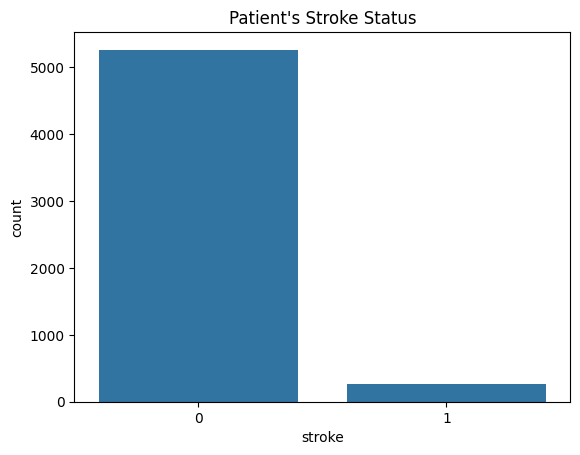

        Number of Values  Proportion of Values
stroke                                        
0                   5259             95.151077
1                    268              4.848923


In [352]:
stroke_values = pd.DataFrame({
    "Number of Values": df_cleaned["stroke"].value_counts(),
    "Proportion of Values": df_cleaned["stroke"].value_counts(normalize= True) * 100
})

sns.countplot(data = df_cleaned, x = "stroke")
plt.title("Patient's Stroke Status")
plt.show()

print(stroke_values)

Analysis of the distribution of values in the `stroke` column shows that there is a significant class imbalance (95% no stroke vs 5% with stroke). Therefore, there is a need to use a stratified split to ensure an equal distribution of both classes amongst the training and test set during the modelling process. Additionally, accuracy would not be a good metric to evaluate the model with such a significant amount of class imbalance, and other metrics (F1, Precision/Recall or ROC-AUC).

## 7. Univariate Analysis for Features

### Numerical Features

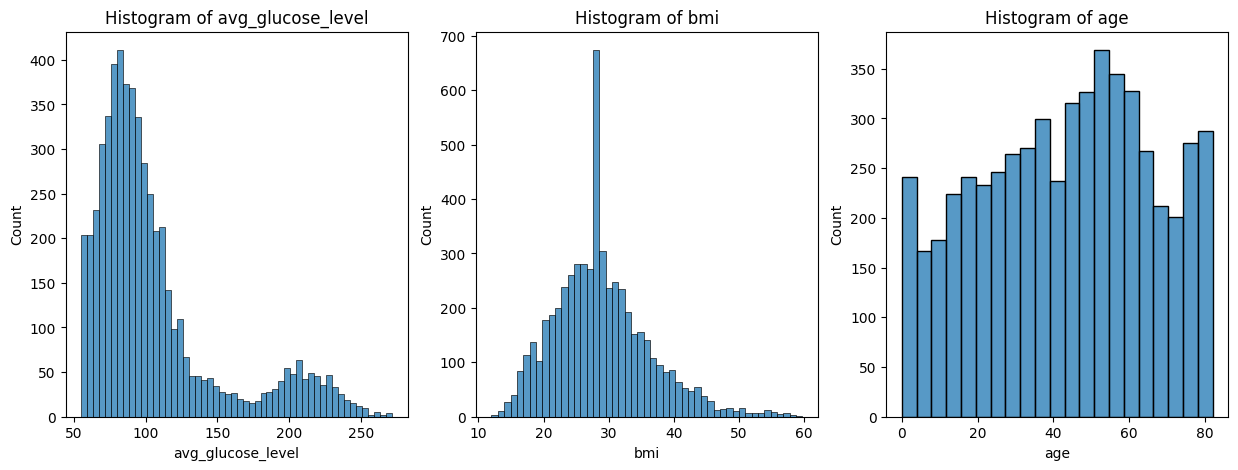

In [353]:
numerical_cols = ["avg_glucose_level", "bmi", "age"]

fig, axes = plt.subplots(1,3,figsize = (15,5))

for i, col in enumerate(numerical_cols):
    sns.histplot(data = df_cleaned, x= col, ax = axes[i])
    axes[i].set_title(f"Histogram of {col}")

plt.show()

**Distribution Analysis:**

`avg_glucose_level`: The distribution is right-skewed, with a majority of the values concentration between 70-150. There appears to be a secondary concentration around 200-250, which indicates a subgroup with diabetes. It would be worth considering to apply a log-transformation or robust scaling to handle the skewed data during model training.

`bmi`: The distribution appears approximately normal, centered around 28-30. There is a large spike in frequency at 29, which corresponds to the imputed median values used to fill missing values. 

`age`: The distribution shows a broad spread across various age groups, with peaks at around 0-4 and 45-65 years old. The dataset also appears more skewed towards older adults.

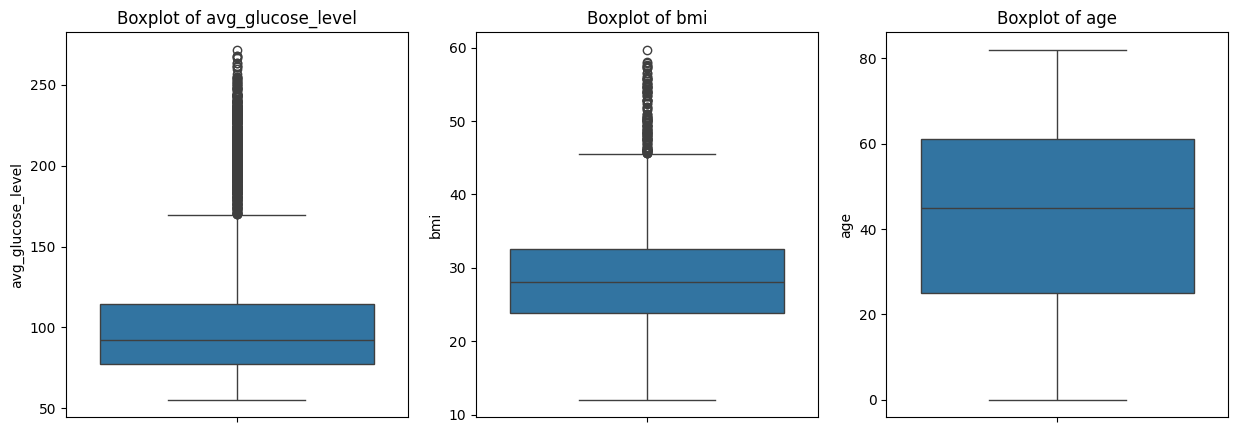

In [354]:
numerical_cols = ["avg_glucose_level", "bmi", "age"]

fig, axes = plt.subplots(1,3,figsize = (15,5))

for i, col in enumerate(numerical_cols):
    sns.boxplot(data = df_cleaned, y = col, ax = axes[i])
    axes[i].set_title(f"Boxplot of {col}")

plt.show()

In [355]:
num_outliers = {}

for col in numerical_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    iqr = Q3 - Q1

    lower_bound = Q1 - 1.5 * iqr
    upper_bound = Q3 + 1.5 * iqr

    outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    num_outliers[col] = {"num_outliers": len(outliers), "proportion_outliers": str(round(len(outliers) / len(df_cleaned) * 100, 2)) + "%"}

print(num_outliers)

{'avg_glucose_level': {'num_outliers': 677, 'proportion_outliers': '12.25%'}, 'bmi': {'num_outliers': 135, 'proportion_outliers': '2.44%'}, 'age': {'num_outliers': 0, 'proportion_outliers': '0.0%'}}


**Outlier Analysis:**

The boxplot of numeric values found a large number of outliers in both `avg_glucose_level` and `bmi` columns. In particular, there are 677 and 135 outliers in the `avg_glucose_level` and `bmi` columns respectively. However, these outliers are kept in the dataset in order to analyse how diabetes and obesity would influence the likelihood of a patient having stroke. No outliers were found in the `Age` column.

During the scaling process, it would be more ideal to use a RobustScaler as opposed to a StandardScaler as it would be less sensitive to outliers.

### Categorical Features

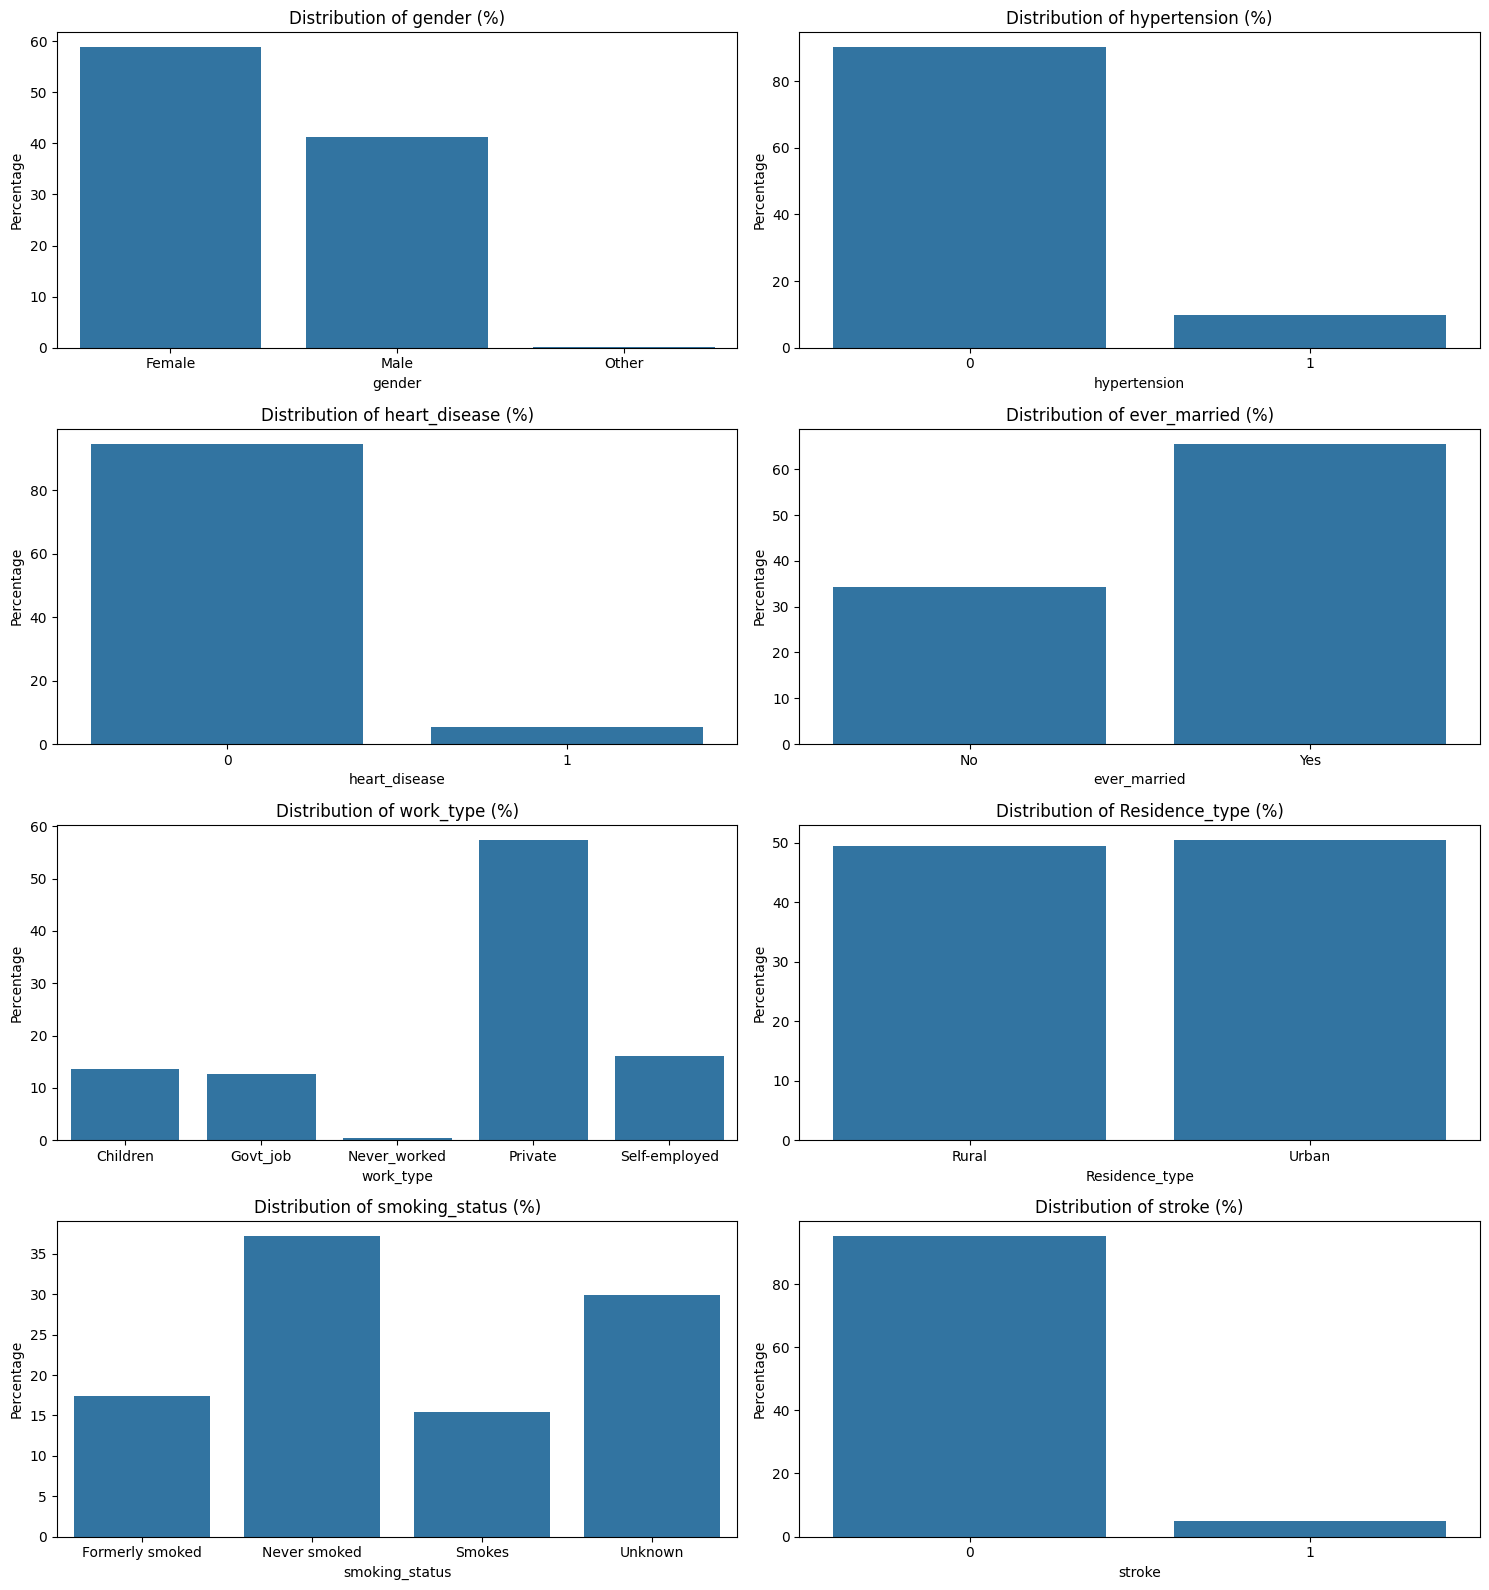

In [356]:
categorical_cols = [col for col in df_cleaned.columns if col not in numerical_cols]
categorical_cols.remove("id")

fig, axes = plt.subplots(4,2, figsize = (15,16))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if i < len(axes): 
        sns.countplot(data=df_cleaned, x=col, ax=axes[i], stat = "percent")
        axes[i].set_title(f"Distribution of {col} (%)")
        axes[i].set_ylabel('Percentage')

for j in range(len(categorical_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


**Distribution Analysis:**

- Balanced Categories: The distributions in the `smoking_status`, `ever_married` & `Residence_type` columns are well-balanced across their respective categories, indicating a fair representation for each group.

- Severely Imbalanced Categories: The `stroke`, `hypertension` and `heart_disease` columns have a significant amount of imbalance, with the positive class ("1") accounting for less than 10% of the data. This class imbalance might impact model performance and should be addressed during training either through resampling or class weighting. 

- Notable Imbalances in Categories: In the `work_type` category, the "Never_worked" group has very few records compared to other employment types. In `gender`, the "Other" category is significantly lower compared to "Male" and "Female", and may need to be excluded during the modelling process.

## 8. Bivariate Analysis of Features and Target

### Numerical Features and Target

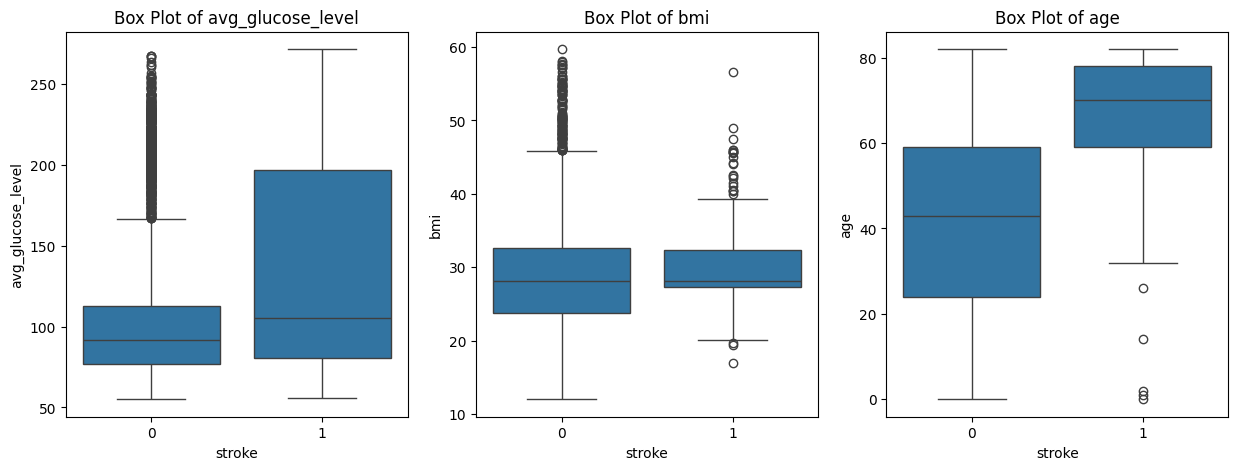

In [357]:
fig, axes = plt.subplots(1,3,figsize = (15,5))

for i, col in enumerate(numerical_cols):
    sns.boxplot(data = df_cleaned, x = "stroke", y= col, ax = axes[i])
    axes[i].set_title(f"Box Plot of {col}")

plt.show()

**Box Plot Analysis:**

`avg_glucose_level`: Patients without stroke have a median blood glucose level of about 90 mg/dl with an IQR of about 30. Stroke patients have a significantly higher median blood glucose level of 110 mg/dl, with an IQR of about 110. Additionally, there are a great number of outlier blood glucose levels in patients without stroke, whereas none are seen in patients with stroke. This indicates that stroke patients have significantly higher blood glucose levels with larger variation, suggesting that pre-diabetes and diabetes might be correlated to stroke risk.

`bmi`: Patients with and without stroke have approximately a median BMI of 28 kg/m2, with very similar distributions and outliers in the high BMI range. This indicates that BMI might have little association with stroke risk.

`age`: The median age for patients without stroke is about 42, with an IQR of approximately 40. In patients with stroke, the median age is substantially higher at about 70 years old with an IQR of 20. Furthermore, the ages of patients without stroke follows a rough normal distribution, whereas those with stroke follow a left-skewed distribution with a few outliers in younger ages. This indicates that the risk of stroke is more constrained towards older patients.

### Categorical Features and Target

In [358]:
categorical_cols.remove("stroke")

for col in categorical_cols:
    crosstab = pd.crosstab(df_cleaned[col], df_cleaned["stroke"], normalize = 'index') * 100
    
    chi2, p_value, dof, expected = chi2_contingency(crosstab)
    print(f"Chi-square Association Test for {col}: \n Chi-Square: {chi2:.3f}, p-value: {p_value:.6f} \n")

Chi-square Association Test for gender: 
 Chi-Square: 5.101, p-value: 0.078052 

Chi-square Association Test for hypertension: 
 Chi-Square: 4.867, p-value: 0.027374 

Chi-square Association Test for heart_disease: 
 Chi-Square: 7.004, p-value: 0.008131 

Chi-square Association Test for ever_married: 
 Chi-Square: 1.862, p-value: 0.172338 

Chi-square Association Test for work_type: 
 Chi-Square: 13.771, p-value: 0.008062 

Chi-square Association Test for Residence_type: 
 Chi-Square: 0.000, p-value: 1.000000 

Chi-square Association Test for smoking_status: 
 Chi-Square: 2.304, p-value: 0.511786 



**Statistical Test Analysis:**

Chi-square tests of independence were conducted to examine the association between categorical features and stroke occurence. The significance level was set at 0.05.

The results of the Chi-square test show that occupational factors (`work_type`) and preexisting medical conditions (`hypertension` and `heart_disease`) are primary categorical predictors for stroke risk as their p-values are below the significance level (0.008062, 0.027374, 0.008131 vs 0.05). On the other hand, demographic factors (`gender`, `ever_married`, `Residence_type`) and lifestyle factors (`smoking_status`)  show no direct association to stroke.

## 9. Bivariate Analysis amongst Features

### Numerical Variables

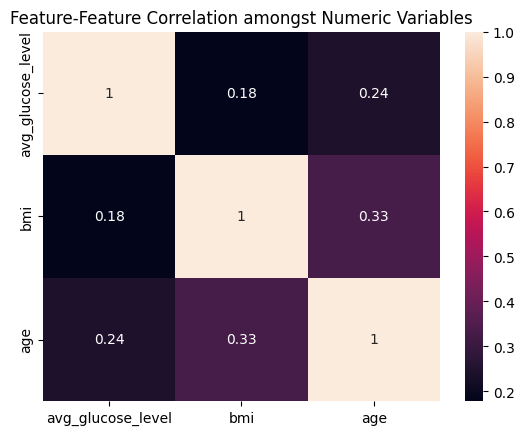

In [359]:
numeric_df = df_cleaned[numerical_cols]

sns.heatmap(numeric_df.corr(), annot = True)
plt.title("Feature-Feature Correlation amongst Numeric Variables")
plt.show()

The heatmap of correlation amongst the numeric variables (`age`, `bmi`, `avg_glucose_level`) has low Pearson coefficient values ranging from 0.18-0.33, indicating that these features are largely independent of each other. This analysis confirms the absence of multicollinearity among numerical preditors, and that there are no redundant features included in the model which might degrade performance and interpretability.

### Categorical Variables

In [360]:
relationship_results = []
feature_pairs = list(combinations(categorical_cols,2))

for feature1, feature2 in feature_pairs:
    chi2_table = pd.crosstab(df_cleaned[feature1], df_cleaned[feature2])
    chi2_stat, p_value, dof, expected = chi2_contingency(chi2_table)

    relationship_results.append({"Feature_1": feature1, "Feature_2": feature2, "p_value": float(round(p_value,4))})

relationship_results = pd.DataFrame(relationship_results)
print(relationship_results.sort_values("p_value"))

         Feature_1       Feature_2  p_value
10    hypertension  smoking_status   0.0000
1           gender   heart_disease   0.0000
3           gender       work_type   0.0000
17    ever_married  smoking_status   0.0000
5           gender  smoking_status   0.0000
6     hypertension   heart_disease   0.0000
7     hypertension    ever_married   0.0000
8     hypertension       work_type   0.0000
15    ever_married       work_type   0.0000
19       work_type  smoking_status   0.0000
11   heart_disease    ever_married   0.0000
12   heart_disease       work_type   0.0000
14   heart_disease  smoking_status   0.0000
2           gender    ever_married   0.0518
20  Residence_type  smoking_status   0.1022
0           gender    hypertension   0.2889
18       work_type  Residence_type   0.5098
4           gender  Residence_type   0.6177
13   heart_disease  Residence_type   0.6678
16    ever_married  Residence_type   0.6870
9     hypertension  Residence_type   0.8132


A Chi-Square test of independence was conducted between pairs of categorical features, with a significance level set at 0.05.

There seems to be a health-related cluster between the pairings of these variables (`hypertension`, `heart_disease`, `smoking_status`) as their p-values were < 0.0001, indicating that there is severe multicollinearity between these features.

There is also a cluster between demographics and lifestyle (`gender` & `heart_disease`, `gender` & `work_type`, `gender` & `smoking_status`, `ever_married` & `smoking_status` and `ever_married` & `work_type`) as their p-values were also < 0.0001. This means that gender has an influence on health outcomes, career choices and lifestyle habits. Marital status also connects to lifestyle and career patterns. Although the `gender` and `ever_married` columns have not shown any direct association to stroke risk in feature-target analysis, they seem to have significant associations with multiple features that have been shown to be a key predictor of stroke.

Additionally, the `Residence_type` feature seems to have no association with other features as their p-values were above the significance level, confirming its lack of predictive value identified in the feature-target analysis.

## 10. Feature Engineering and Selection

In [361]:
df_modelling = df_cleaned.drop(["id", "Residence_type", "gender", "ever_married"], axis = 1)
df_modelling.head()

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,23,0,0,Private,92.26,17.1,Unknown,0
1,82,0,0,Self-employed,82.21,26.0,Never smoked,0
2,26,0,0,Private,103.61,31.4,Never smoked,0
3,13,0,0,Children,94.12,20.1,Never smoked,0
5,7,0,0,Children,87.94,28.1,Unknown,0


The following columns were dropped for the remainder of this analysis:

`id`: An unique patient identifier that has no statistical meaning to the analysis, and only serves to weed out duplicate patient records.

`Residence_type`: Significant high p-value (1.000 vs 0.05) in the Chi-square test for target-feature analysis indicates that it is independent of stroke onset in patients.

`gender` & `ever_married`: High p-values above significance level in the Chi-square test for target-feature analysis (0.078052 in `gender` & 0.172338 in `ever_married`), indicating that they are weak predictors of stroke. Additionally, these features have high multicollinearity with other strong predictors, which would interfere with model performance.

The columns for `smoking_status` and `bmi` were kept for analysis despite the results of the target-feature relationship. Despite the high p-value in the Chi-Square analysis of `smoking_status` and `stroke` (0.511786), and the lack of difference in distribution and median values in the boxplot, literature reviews suggest otherwise that BMI and smoking history are in fact strong predictors of stroke. As such, their values are kept for the modelling process.

In [362]:
# Encoding Smoking Status Column
smoking_scoring = {

    "Unknown": 0,
    "Never smoked": 0,
    "Formerly smoked": 0.5,
    "Smokes": 1

}

df_modelling["smoking_status"] = df_modelling["smoking_status"].replace(smoking_scoring)

# Encoding Work Type Column

work_type_encoded = pd.get_dummies(df_modelling["work_type"], prefix= 'work')
df_modelling = pd.concat([df_modelling.drop(["work_type"],axis=1), work_type_encoded], axis = 1)
df_modelling.to_csv("../data/stroke_dataset_modelling.csv")

df_modelling.head()

/var/folders/7t/qj85ttzs5jzfv55wltyfltvw0000gn/T/ipykernel_80815/399792149.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_modelling["smoking_status"] = df_modelling["smoking_status"].replace(smoking_scoring)
/var/folders/7t/qj85ttzs5jzfv55wltyfltvw0000gn/T/ipykernel_80815/399792149.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_modelling["smoking_status"] = df_modelling["smoking_status"].replace(smoking_scoring)


,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,work_Children,work_Govt_job,work_Never_worked,work_Private,work_Self-employed
0,23,0,0,92.26,17.1,0.0,0,False,False,False,True,False
1,82,0,0,82.21,26.0,0.0,0,False,False,False,False,True
2,26,0,0,103.61,31.4,0.0,0,False,False,False,True,False
3,13,0,0,94.12,20.1,0.0,0,True,False,False,False,False
5,7,0,0,87.94,28.1,0.0,0,True,False,False,False,False


The `smoking_status` column was ordinally encoded to reflect potential health risks: "Unknown" and "Never smoked" were encoded as 0. "Smokes" were encoded as 1 to reflect active risk, and "Formerly smoked" was encoded as 0.5 to capture any residual effects of past smoking.

For the `work_type` column, one-hot encoding was used to avoid introducing ordinality. Dummy variables were created using the "work_" prefix and the original columns were dropped.